# Phase 6: Hyperparameter Tuning

In this notebook, we optimize our Random Forest model. We will move from "default" parameters to a set of parameters specifically tuned for the Telco Churn dataset.

### 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.config import PROCESSED_DATA_DIR
from src.hyperparameter_tuning import perform_hyperparameter_tuning
from src.model_training import train_random_forest, evaluate_model_test, plot_model_performance

# Load processed data
X_train = pd.read_csv(PROCESSED_DATA_DIR / 'X_train.csv')
X_test = pd.read_csv(PROCESSED_DATA_DIR / 'X_test.csv')
y_train = pd.read_csv(PROCESSED_DATA_DIR / 'y_train.csv').values.ravel()
y_test = pd.read_csv(PROCESSED_DATA_DIR / 'y_test.csv').values.ravel()

### 2. Establish Baseline (Before Tuning)
We need to know where we started to measure improvement.

In [2]:
print("Training Default Model (Baseline)...")
# Default parameters (roughly what we used in Phase 4)
default_model = train_random_forest(X_train, y_train, class_weight='balanced')
metrics_before, _, _ = evaluate_model_test(default_model, X_test, y_test)

print("Baseline Performance:")
display(pd.DataFrame(metrics_before, index=['Before Tuning']).T)

Training Default Model (Baseline)...
Baseline Performance:


,Before Tuning
accuracy,0.775089
precision,0.560086
recall,0.701613
f1,0.622912
roc_auc,0.837319


### 3. Run Randomized Search
We use `RandomizedSearchCV` because it is efficient. It tests random combinations of parameters to find the "sweet spot" without testing every single possibility.

In [3]:
# Run Tuning (This may take 2-5 minutes)
best_model, tuning_results = perform_hyperparameter_tuning(X_train, y_train, method='random')

Starting Random Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Tuning Completed in 1.3 minutes.
Best F1 Score: 0.6409
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced'}


### 4. Compare Performance (Before vs. After)
Let's see if the computer found a better configuration than our manual guess.

,Before Tuning,After Tuning
accuracy,0.775089,0.771530
precision,0.560086,0.551935
recall,0.701613,0.728495
f1,0.622912,0.628042
roc_auc,0.837319,0.842198


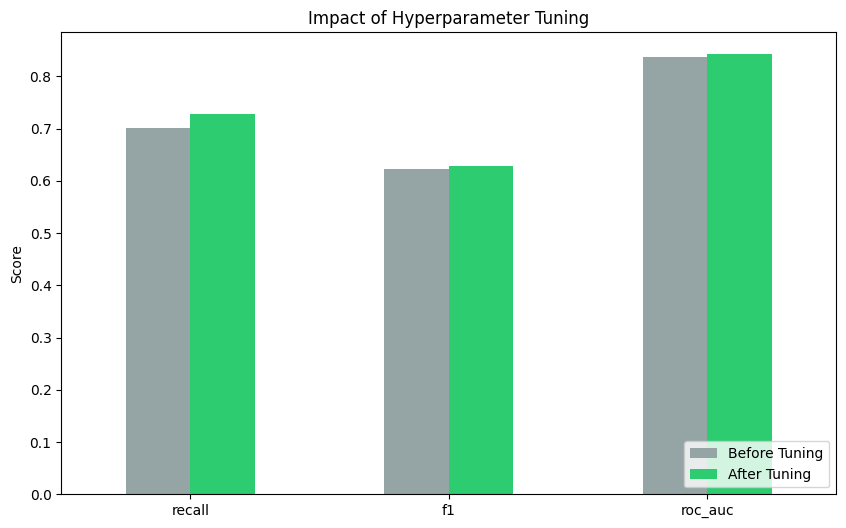

In [4]:
# Evaluate the Tuned Model
metrics_after, y_pred_tuned, y_prob_tuned = evaluate_model_test(best_model, X_test, y_test)

# Combine into a comparison table
comparison = pd.DataFrame([metrics_before, metrics_after], index=['Before Tuning', 'After Tuning'])
display(comparison.T)

# Visualization
metrics_to_plot = ['recall', 'f1', 'roc_auc']
comparison[metrics_to_plot].T.plot(kind='bar', figsize=(10, 6), color=['#95a5a6', '#2ecc71'])
plt.title('Impact of Hyperparameter Tuning')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

### 5. Analyze the "Winning" Parameters
Understanding *why* the parameters changed gives us data science insights.

In [5]:
print("Winning Hyperparameters:")
print(best_model.get_params())

# Insight generation
if best_model.min_samples_leaf > 1:
    print("\nInsight: The tuner increased 'min_samples_leaf'. This means the default model was likely overfitting, and the new model is more generalized.")
if best_model.n_estimators > 100:
    print("\nInsight: The tuner added more trees, which increases stability.")

Winning Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Insight: The tuner increased 'min_samples_leaf'. This means the default model was likely overfitting, and the new model is more generalized.

Insight: The tuner added more trees, which increases stability.


In [6]:
from src.model_training import save_model
save_model(best_model, 'final_champion_tuned.joblib')

Model saved successfully to: c:\Users\ishfa\datascience\customer-churn-prediction\models\final_champion_tuned.joblib
